## References

- [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

- [lil's log](https://lilianweng.github.io/posts/2017-07-08-stock-rnn-part-1/)

- [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

- [Backpropagation through time](https://colab.research.google.com/drive/1NzKaQaZ-vuwjgcXreP-rXRk1Lk5nPPZW?authuser=0#scrollTo=kB1OLzOqn_T8)

- [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)

- [RNN with Keras](https://medium.com/@researchgraph/beginners-guide-to-recurrent-neural-networks-rnns-with-keras-7b8eb408caa1)

### papers

- [LONG SHORT-TERM MEMORY](http://www.bioinf.jku.at/publications/older/2604.pdf)

In [1]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PBR.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-08-24,14.58,14.67,14.34,14.49,12.385379,15296100
1,2023-08-25,14.50,14.50,14.20,14.31,12.231524,21185700
2,2023-08-28,14.28,14.53,14.22,14.50,12.393928,18657700
3,2023-08-29,14.44,14.63,14.35,14.58,12.462306,16231400
4,2023-08-30,14.58,14.66,14.54,14.54,12.428117,11264100


In [2]:
from pandas import read_csv
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
#Read data from given url and extract the second column
def read_data(url):
    df = read_csv(url, usecols=[2], engine='python')
    data = np.array(df.values.astype('float32'))
#Normalise data into (0,1) range
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    return data, n

sunspots_url = '/content/drive/MyDrive/Colab Notebooks/PBR.csv'
data, n = read_data(sunspots_url)

In [4]:
#Splitting data into train and test based on split ratio
def get_train_test(split_percent, data):
    n = len(data)
    split = int(n * split_percent)
    train_data = data[:split]
    test_data = data[split:]
    return train_data, test_data

split_percent = 0.80
train_data, test_data = get_train_test(split_percent, data)

In [5]:
#Reshape data into input-output pairs with specified time steps
def get_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)
#Prepare Training and testing data
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))
    return X, Y

In [6]:
time_steps = 12
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

In [7]:
#Define the RNN model
def create_RNN(units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=input_shape,
                        activation=activation[0], return_sequences=True))
    model.add(Dense(dense_units, activation=activation[1]))
#Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


In [8]:
model = create_RNN(units=3, dense_units=1, input_shape=(time_steps,1),
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
16/16 - 5s - 306ms/step - loss: 0.1135
Epoch 2/10
16/16 - 0s - 19ms/step - loss: 0.0880
Epoch 3/10
16/16 - 0s - 21ms/step - loss: 0.0733
Epoch 4/10
16/16 - 0s - 16ms/step - loss: 0.0630
Epoch 5/10
16/16 - 0s - 19ms/step - loss: 0.0581
Epoch 6/10
16/16 - 0s - 19ms/step - loss: 0.0545
Epoch 7/10
16/16 - 0s - 16ms/step - loss: 0.0522
Epoch 8/10
16/16 - 0s - 11ms/step - loss: 0.0503
Epoch 9/10
16/16 - 0s - 25ms/step - loss: 0.0487
Epoch 10/10
16/16 - 0s - 15ms/step - loss: 0.0472


In [11]:
#Get error of predictions to evaluate it
def print_error(trainY, testY, train_predict, test_predict):
    train_predict = train_predict.reshape(-1)
    test_predict = test_predict.reshape(-1)
    train_rmse = math.sqrt(mean_squared_error(trainY,train_predict[:16]))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict[:4]))
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))
    #print(f"trainY shape: {trainY.shape}, train_predict shape: {train_predict.shape}")
    #print(f"testY shape: {testY.shape}, test_predict shape: {test_predict.shape}")

#Make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
#Mean square error
print_error(trainY, testY, train_predict, test_predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Train RMSE: 0.214 RMSE
Test RMSE: 0.283 RMSE


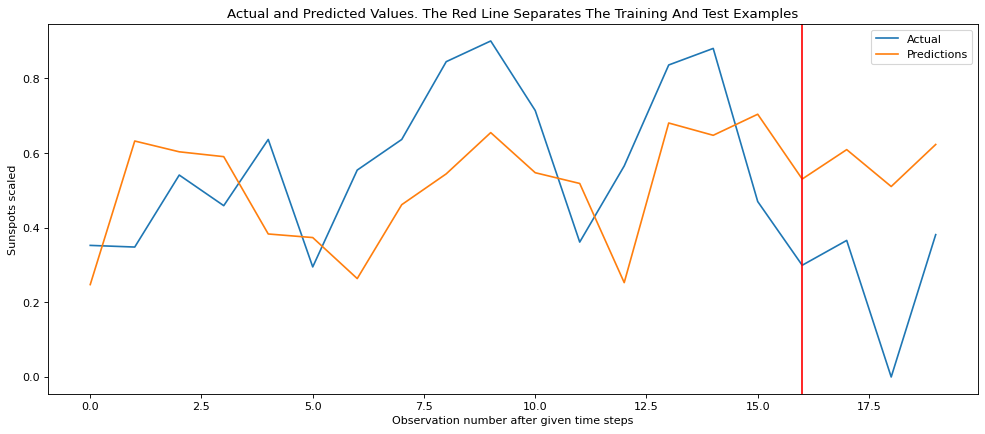

In [12]:
#Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions[:20])
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

plot_result(trainY, testY, train_predict, test_predict)